In [28]:
import pandas as pd
import numpy as np
from pathlib import Path

from utilities.nn_utils import *
from utilities.data_augmenting import corr2clusters

from IPython.display import display, Markdown
from tqdm.notebook import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import networkx as nx
import community as community_louvain

In [83]:
def winsorize_dataframe(df, lower_quantile=0.05, upper_quantile=0.95):
    df_winsorized = df.copy()
    limits = {}

    for column in df_winsorized.select_dtypes(include=[np.number]).columns:
        lower_limit = df_winsorized[column].quantile(lower_quantile)
        upper_limit = df_winsorized[column].quantile(upper_quantile)

        # Store the limits for each column
        limits[column] = {'min': lower_limit, 'max': upper_limit}

        # Cap the values to the calculated limits
        df_winsorized[column] = np.clip(df_winsorized[column], lower_limit, upper_limit)

    return df_winsorized, limits


def apply_winsorization_limits(df, limits):
    df_clipped = df.copy()

    for column, bound in limits.items():
        if column in df_clipped.columns:
            df_clipped[column] = np.clip(df_clipped[column], bound['min'], bound['max'])

    return df_clipped

def column2onehot(x_table, column, ohencoder=None):
    if ohencoder is None:
        ohencoder = OneHotEncoder(handle_unknown='ignore').fit(x_table[column].values.reshape(-1, 1))
    ohe_values = ohencoder.transform(x_table[column].values.reshape(-1, 1)).toarray()
    column_names = [f'{column}_ohe_{i}' for i in range(ohe_values.shape[1])]
    ohe_df = pd.DataFrame(index=x_table.index, columns=column_names)
    ohe_df.iloc[:] = ohe_values
    return ohe_df, ohencoder

In [4]:
data_path = Path("/Users/adamsulik/Workspace/qrt_datachallenge/data")

In [5]:
x_train = pd.read_csv(data_path / 'x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv(data_path / 'y_train_JQU4vbI.csv', index_col='ID')

x_test = pd.read_csv(data_path / 'x_test_c7ETL4q.csv', index_col='ID')

In [6]:
train_stock = pd.Index(x_train['STOCK'].unique())
test_stock = pd.Index(x_test['STOCK'].unique())

In [101]:
df_melted = pd.concat([x_train, x_test])[['STOCK', 'DATE']+[f'RET_{i}' for i in range(1, 10)]]\
                .melt(id_vars=['STOCK', 'DATE'],var_name="RET_TYPE", value_name="RET_VALUE")
df_melted["RET_DATE"] = df_melted["RET_TYPE"] + "_" + df_melted["DATE"].astype(str)
df_pivot = df_melted.pivot(index="STOCK", columns="RET_DATE", values="RET_VALUE")
df_pivot = df_pivot.sort_index(axis=1)
df_pivot.columns.name = None
corr = df_pivot.T.corr().astype(float).fillna(0)

filtered_corr = corr.where(corr >= .45, other=0)
G = nx.from_pandas_adjacency(filtered_corr)
partition = community_louvain.best_partition(G, weight='weight', random_state=42)
groups = pd.DataFrame(list(partition.items()), columns=["STOCK", "Group"])['Group']

# Apply groups to sets
train_with_groups = x_train.merge(groups, left_on='STOCK', right_index=True)
test_with_groups = x_test.merge(groups, left_on='STOCK', right_index=True)

In [119]:
def prepare_data(xdf, days_back, winsor_limits=None, ohencoder=None, upper_ohencoder=None):
    xdf.replace([np.inf, -np.inf], np.nan, inplace=True)
    xdf.fillna(0, inplace=True)
    # pick relevant columns
    all_ret_columns = [c for c in xdf.columns if c.startswith('RET_')]
    ret_columns = [f'RET_{i}' for i in range(1, days_back+1)]
    vol_columns = [f'VOLUME_{i}' for i in range(1, days_back+1)]
    group_columns = ['Group']#, 'upper_group']
    numerical_columns = ret_columns+vol_columns
    rel_columns = ret_columns+vol_columns+group_columns
    
    xdf = xdf[['DATE'] + rel_columns]
    
    # normalize returns by std
    ret_std = xdf[ret_columns].std(axis=1).fillna(1)
    xdf.loc[:, ret_columns] = xdf[ret_columns].fillna(0).values / ret_std.values[:, np.newaxis]
    
    # winsorize volumes and returns
    if not winsor_limits:
        xdf.loc[:, numerical_columns], winsor_limits = winsorize_dataframe(xdf[numerical_columns], lower_quantile=0.01, upper_quantile=0.99)
    else:
        xdf = apply_winsorization_limits(xdf, winsor_limits)

    group_stats = xdf.groupby(['DATE', 'Group'])[['RET_1']]\
                     .agg(['mean', 'std'])['RET_1']\
                     .rename(columns={'mean': 'group_mean', 'std': 'group_std'})
    group_stats2 = xdf.groupby(['DATE', 'Group'])[['RET_2']]\
                     .agg(['mean', 'std'])['RET_2']\
                     .rename(columns={'mean': 'group_mean2', 'std': 'group_std2'})
    
    group_vol_stats = xdf.groupby(['DATE', 'Group'])[['VOLUME_1']]\
                     .agg(['mean', 'std'])['VOLUME_1']\
                     .rename(columns={'mean': 'group_vol_mean', 'std': 'group_vol_std'})
    
    xdf = xdf.merge(group_stats, on=['DATE', 'Group'])
    xdf = xdf.merge(group_stats2, on=['DATE', 'Group'])
    xdf = xdf.merge(group_vol_stats, on=['DATE', 'Group'])

    rel_columns = rel_columns + ['group_mean', 'group_std', 'group_mean2', 'group_std2', 'group_vol_mean', 'group_vol_std']
    xdf = xdf[rel_columns]

    # Group encoding
    group_encoding, ohencoder = column2onehot(xdf, 'Group', ohencoder)
    xdf = xdf.join(group_encoding).drop(columns=['Group'])
    
    return xdf, winsor_limits, ohencoder#, upper_ohencoder

In [121]:
days_back = 5

processed_x_train, winsor_limits, ohencoder = prepare_data(train_with_groups, days_back=days_back)
processed_x_test, _, _ = prepare_data(test_with_groups, days_back=days_back, winsor_limits=winsor_limits, ohencoder=ohencoder)

/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_34047/2454939815.py:16: RuntimeWarning: invalid value encountered in divide
  xdf.loc[:, ret_columns] = xdf[ret_columns].fillna(0).values / ret_std.values[:, np.newaxis]
/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_34047/2454939815.py:16: RuntimeWarning: invalid value encountered in divide
  xdf.loc[:, ret_columns] = xdf[ret_columns].fillna(0).values / ret_std.values[:, np.newaxis]


# Train model

In [ ]:
SEED = 42
NUM_WORKERS = 10
PRINT_EVERY=1
EPOCHS = 15

device = choose_device()
learning_rate = 1e-3
model_hidden_layers = [8, 8]
dropout_rate = [0.4, 0.4]
X = processed_x_train.astype(float).fillna(0).values
Y = y_train['RET'].astype(int).values
dates_arr = x_train['DATE']

# Standarize numerical values
# scaler = StandardScaler().fit(X)
# X = scaler.transform(X)

# run k-fold cv
cv_results = run_k_fold_training(X, Y, random_seed=SEED, num_workers=NUM_WORKERS, device=device, epochs=EPOCHS,
                                 split_type='date', date_array=dates_arr, print_every_epoch=PRINT_EVERY,
                                 lr=learning_rate, model_hidden_layers=model_hidden_layers, dropout_rate=dropout_rate
                                )

In [ ]:
cv_results = pd.DataFrame(cv_results)#.set_index('fold')
avg_acc = cv_results['accuracy'].mean()
std_acc = cv_results['accuracy'].std()

upper_bound_acc = avg_acc + std_acc
lower_bound_acc = avg_acc - std_acc

print(f'Accuracy: {avg_acc:.5f} [{lower_bound_acc:.5f}; {upper_bound_acc:.5f}] (+- {std_acc:.6f}), based on 4 kfolds')

Train on full dataset

In [ ]:
SEED = 42
NUM_WORKERS = 10
PRINT_EVERY=5
EPOCHS = 100
learning_rate = 1e-3

model_hidden_layers = [8, 16]
dropout_rate = [0.6, 0.4]

exp_name = f'{days_back}d-nn-uppergroup_with_group_hierarchical'
savedir = data_path.parent / 'outputs' / 'grouped_double_nn'
savedir.mkdir(exist_ok=True, parents=True)
date_array = x_train['DATE']

ret_columns = [c for c in processed_x_train.columns if c.startswith('RET_')]
vol_columns = [c for c in processed_x_train.columns if c.startswith('VOLUME_')]
group_stats_columns = ['upper_group_mean', 'upper_group_std', 'group_mean', 'group_std']
ohe_columns = [c for c in processed_x_train.columns if (c.startswith('Group_ohe') or c.startswith('upper_group_ohe'))]
numerical_columns = ret_columns + vol_columns
rel_columns = ret_columns + vol_columns + group_stats_columns + ohe_columns

X = processed_x_train[rel_columns].astype(float).fillna(0).values
Y = y_train['RET'].astype(int).values

model_checkpoint, model_stats_df = full_dataset_training(
    X, Y,
    numerical_columns=numerical_columns,
    output_storage_path=savedir,
    bestmodel_exp_name=exp_name,
    val_split=0.1,
    batch_size=32,
    epochs=EPOCHS,
    seed=SEED,
    print_every_epoch=PRINT_EVERY,
    num_workers=NUM_WORKERS, device=choose_device(), lr=learning_rate,
    model_hidden_layers=model_hidden_layers, dropout_rate=dropout_rate,
    split_type='date', date_array=date_array,
    crit_metric_name = 'accuracy',
)

In [61]:
for k in ['epoch', 'train_acc', 'val_acc']:
    print(k, model_checkpoint[k])

epoch 20
train_acc 0.515890865128262
val_acc 0.51200925530042


In [62]:
# setup variables
exp_name = f'{days_back}d-nn-uppergroup_with_group_hierarchical'
savedir = data_path.parent / 'outputs' / 'grouped_double_nn'
X_eval = processed_x_test.astype(float).values

model_checkpoint = torch.load(savedir / f'{exp_name}.pt', map_location=device)

probs = load_model_and_predict(savedir / f'{exp_name}.pt', X_eval,
                               numerical_columns=numerical_columns,
                               model_hidden_layers = [8, 16],
                              )

/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_92509/2662149234.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load(savedir / f'{ex

In [72]:
# probs
eval_probs = pd.Series(probs, index=x_test.index)
pred = (eval_probs > .5)
pred.to_csv(savedir / 'pred.csv')

# Run training on trees

In [122]:
ret_columns = [c for c in processed_x_train.columns if c.startswith('RET_')]
vol_columns = [c for c in processed_x_train.columns if c.startswith('VOLUME_')]
group_stats_columns = ['group_mean', 'group_std', 'group_mean2', 'group_std2', 'group_vol_mean', 'group_vol_std']
ohe_columns = [c for c in processed_x_train.columns if (c.startswith('Group_ohe') or c.startswith('upper_group_ohe'))]
numerical_columns = ret_columns + vol_columns
rel_columns = ret_columns + vol_columns + group_stats_columns

X_train = processed_x_train[rel_columns].astype(float).fillna(0)
Y = y_train['RET'].astype(int)

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = x_train['DATE'].unique()
test_dates = x_test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = x_train['DATE'].isin(local_train_dates)
    local_test_ids = x_train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = Y.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = Y.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = x_train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.05%
Fold 2 - Accuracy: 50.27%
Fold 3 - Accuracy: 51.38%
Fold 4 - Accuracy: 50.57%
Accuracy: 50.82% [50.39 ; 51.24] (+- 0.43)


<Axes: >

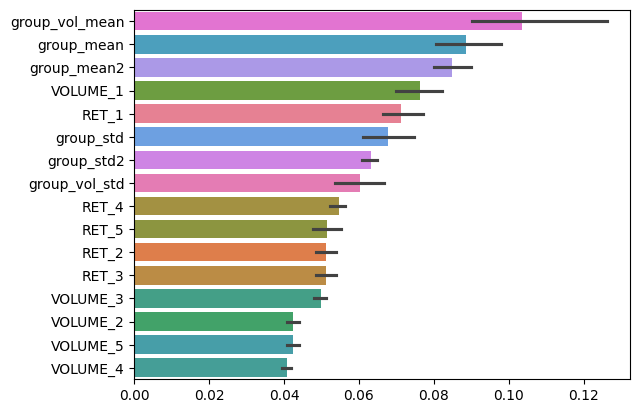

In [123]:
import seaborn as sns

feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=rel_columns)
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)